# E-commerce — Анализ товарного ассортимента

**Цель исследования:**  
Для интернет-магазина товаров для дома и быта необходимо провести анализ ассортимента товаров, выделить основные  и дополнительные категории, что поможет расставить приоритеты и оптимизировать закупки.

**Заказчик:**  
менеджер товарного ассортимента 

**План исследования:**
1. Предобработка данных
2. Исследовательский анализ данных
3. Проведение анализа ассортимента
4. Статистическая проверка гипотез

---

## Предобработка данных

### Импорт библиотек и загрузка датасета

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymystem3 import Mystem
from collections import Counter
import scipy.stats as stats

sns.set_palette('vlag')

data = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

In [3]:
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


- Датасет состоит из около 7.5 тыс. строк
- Пропуски отсутствуют
- Типы данных требуют преведения в корректные типы:  
`date` (int -> datetime) ; `order_id` (int -> str)

---

### Преобразование типов данных

In [5]:
# преобразование date (int -> datetime)
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

# преобразование order_id (int -> str)
data['order_id'] = data['order_id'].astype('str')

In [6]:
# проверка преобразования даты и времени
data['date'].head(10)

0   2018-10-01 00:00:00
1   2018-10-01 00:00:00
2   2018-10-01 00:00:00
3   2018-10-01 00:00:00
4   2018-10-01 00:00:00
5   2018-10-01 00:00:00
6   2018-10-01 00:00:00
7   2018-10-01 08:00:00
8   2018-10-01 08:00:00
9   2018-10-01 09:00:00
Name: date, dtype: datetime64[ns]

### Поиск дубликатов и проверка логики данных

In [7]:
# поиск явных дубликатов
data.duplicated().sum()

0

**Проверим датасет на следующие логические утверждения:**
- у заказа может быть только один пользователь
- для всех товаров внутри одного заказа должно быть одинаковое время оформления заказа
- внутри одного заказа не может быть несколько строк для одинаковых товаров (количество одного и того же товара должно отображаться в столбце `quantity`) 

---

In [8]:
# проверка логики: заказ не может иметь нескольких пользователей одновременно
multi_user_orders = data.groupby('order_id')['customer_id'].nunique().sort_values(ascending=False)
print(multi_user_orders)

# количество таких заказов
print((multi_user_orders>1).sum())

# список таких заказов
multi_user_orders = multi_user_orders[multi_user_orders>1].index

order_id
72845    4
69485    3
71480    3
69283    2
69833    2
        ..
68663    1
68667    1
68668    1
68670    1
73164    1
Name: customer_id, Length: 3521, dtype: int64
29


**29 заказов имеют одновременно несколько пользователей**, что врятли может соответствовать реальности.

---

In [9]:
# проверка логики: позиции внутри одного заказа не могут иметь разное время оформления
multi_time_orders = data.groupby('order_id')['date'].nunique().sort_values(ascending=False)
print(multi_time_orders)

# количество таких заказов
print((multi_time_orders>1).sum())

# список таких заказов
multi_time_orders = multi_time_orders[multi_time_orders>1].index

order_id
14833    74
70960    60
69162    23
71148    16
69531    12
         ..
68681     1
68682     1
68683     1
68685     1
73164     1
Name: date, Length: 3521, dtype: int64
284


**284 заказа имеют различное время оформления для своих позиций**, что также неправдоподобно.

---

In [10]:
# проверка логики: внутри одного заказа не может быть несколько строк для одинаковых товаров
multi_product_orders = data[data[['order_id','product']].duplicated()]

print('Количество дублирующихся позиций внутри заказа:', len(multi_product_orders))
print('Количество проблемных заказов:', multi_product_orders['order_id'].nunique())

Количество дублирующихся позиций внутри заказа: 1920
Количество проблемных заказов: 278


**в 278 заказах имеется 1920 дублирующихся позиций**, что странно, так как количество товара должно отображатся в отдельном столбце, а не дублироваться новой позицией в заказе.

---

**Вывод после проверки логики данных:**  
- Удалить 29 заказов, которые имеют одновременно несколько пользователей.
- Около 284 заказов имеют разное время оформления для своих позиций и примерно столько же (278) заказов имеют множество дублирующихся позиций, что наводит на предположение, что при сборе в данные попали не только завершенные транзакции, но и неудачные. 

**Поэтому все кроме последней записи по времени по одному и тому же заказу и товару можно считать неудачными транзакциями и удалить из датасета.**

- Удалить заказы, которые имеют различное время оформления для своих позиций.

### Очистка исходных данных

In [11]:
# удаление заказов, которые имеют одновременно несколько пользователей и различное время оформления для своих позиций
clean_data = data.query('order_id not in @multi_user_orders and order_id not in @multi_time_orders').sort_values(by='date')

In [12]:
# удаление неудачных транзакций
clean_data.drop_duplicates(subset=['order_id', 'product'], keep='last', inplace=True)

In [13]:
# очищенные данные
clean_data.reset_index(drop=True, inplace=True)
clean_data

,date,customer_id,order_id,product,quantity,price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
...,...,...,...,...,...,...
4996,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38.0
4997,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0
4998,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354.0
4999,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128.0


**Итого были удалены заказы с одновременно несколькими пользователями, неудачные транзакции, заказы с различным временем оформления для своих позиций (2473 записей или 33% первоначального датасета)**

---

### Добавление вспомогательных столбцов

In [14]:
# добавление столбца с итоговой суммой по позиции в заказе
clean_data['total'] = clean_data['quantity'] * clean_data['price']

## Исследовательский анализ данных
Задачи исследовательского анализа:
- Изучить распределение значений в числовых столбцах (кол-во товаров, цена)(describe + визуализации)
- Выявить возможные аномалии в данных, изучить их влияние на весь датасет и целесообразность их удаления
- Подготовить окончательный очищенный датасет для дальнейшего анализа

- Изучить динамику заказов/выручки в период исследования
- Изучить динамику среднего чека
- Изучить пользователей (динамика количества пользователей, количество заказов/выручка на одного пользователя, периодичность заказов)

---

### Выявление аномальных значений и их удаление

In [15]:
round(clean_data.describe(),2)

,quantity,price,total
count,5001.00,5001.00,5001.00
mean,2.56,540.79,854.64
std,17.03,995.31,9687.47
min,1.00,9.00,9.00
25%,1.00,90.00,120.00
50%,1.00,150.00,194.00
75%,1.00,539.00,734.00
max,1000.00,14917.00,675000.00


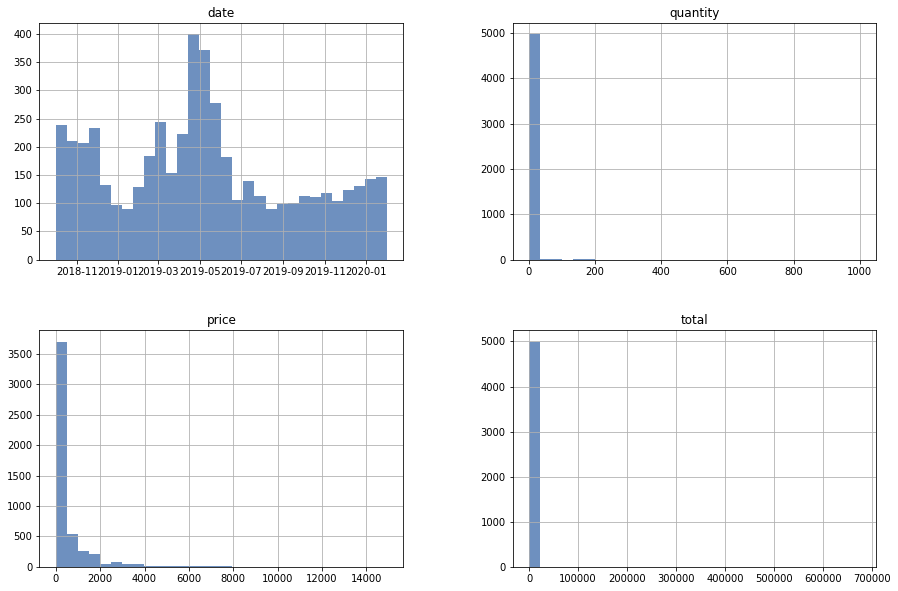

In [16]:
# визуализируем распредление значений в числовых столбцах
clean_data.hist(figsize=(15,10), bins=30);

- Временной период исследования транзакций: с октября 2018 по январь 2020 (16 месяцев)
- Пик активности транзакций приходится на апрель-май 2019 года
- Во столбцах `quantity`, `price`  и `total` присутствуют аномально высокие значения:
    - Например 1000 штук одной позиции в заказе, в то время как подавляющее большинство позиций имеет товар в 1 экземпляре;
    - Самый дорогой товар - около 15 тыс.руб., в то время как 3/4 всех товаров стоят меньше 539 руб., а медианая цена товара по выборке - 150 руб.;
    - Стоимость позиции в заказе - 675 тыс.руб., в то время как 3/4 всех позиций не превышают 734 руб., а медианная стоимость позиции по выборке 194 руб.
    
---

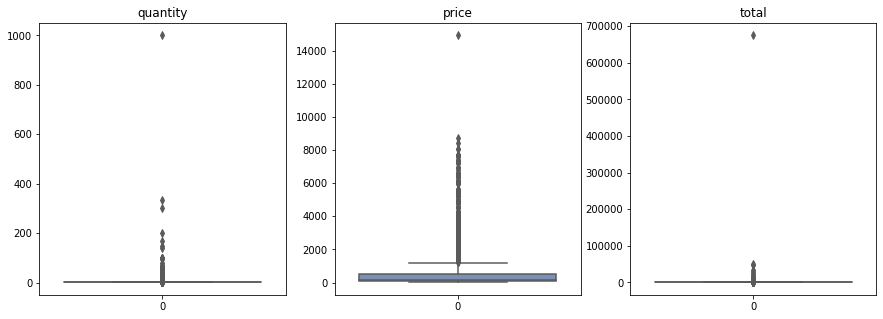

In [17]:
# рассмотрим аномальные значения на ящике с усами
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for x,n in zip(['quantity', 'price', 'total'], range(3)):
        sns.boxplot(data = clean_data[x], ax=axes[n])
        axes[n].set_title(x)

In [18]:
# рассмотрим выбросы для количества товара в позиции заказа
clean_data.query('quantity >= 100').sort_values(by='quantity')

,date,customer_id,order_id,product,quantity,price,total
882,2018-12-04 17:00:00,7d255526-fcc2-4f79-b28a-217d7d2373a8,69206,"Щетка для посуды *ОЛЯ*, Мультипласт 1807010",100,26.0,2600.0
1192,2019-01-21 09:00:00,8eabcaca-e8c8-4eee-9079-4ff5f612273a,69893,Щетка для мытья посуды КОЛИБРИ М5202 большая,100,34.0,3400.0
4113,2019-10-07 11:00:00,d933280e-5372-448f-be44-b269c8bafc2a,72885,"Крепеж для пружины дверной оцинкованный, 1107054",100,19.0,1900.0
4240,2019-10-28 10:00:00,018fb729-3525-4314-8e4d-1982b1062f9f,73110,"Шпингалет 80 мм белый с пружиной, 1102188",100,44.0,4400.0
448,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,8260.0
1842,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0,3000.0
430,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,8670.0
922,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,5800.0
3006,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,15300.0
3311,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0


Нереалистичными представляются позиция с 1000 Вантузами с итоговой стоимостью 675 тыс. руб. и 334 вешалки на 49.4 тыс.руб.  
Возможными, но нетипичными представляются позиции с муляжами яблок (по 140, 170, 300 штук), плечики (150шт.) и ручки-скобки(200шт.)
Остальные товары имеют низкую стоимость и по своему характеру могут закупаться в большом количестве.  
**Примем за аномалии значения количества товара в позиции больше 100 штук.**

In [19]:
# удаление аномалий
clean_data = clean_data.query('quantity <= 100')

In [20]:
# рассмотрим выбросы для цены товара
print('Позиций со стоимостью товара больше 2000 руб.:', len(clean_data.query('price > 2000')))

Позиций со стоимостью товара больше 2000 руб.: 293


In [21]:
# рассмотрим выбросы для цены товара
clean_data.query('price > 8000')

,date,customer_id,order_id,product,quantity,price,total
1518,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,Сумка-тележка хозяйственная Andersen Alu Star ...,1,8437.0,8437.0
2039,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,Сумка-тележка хозяйственная Andersen Royal Sho...,1,8737.0,8737.0
2254,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo...,1,8077.0,8077.0
3679,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.0,14917.0
4963,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,Сумка-тележка хозяйственная Rolser MNB019 rojo...,1,8077.0,8077.0


293 транзакции (около 5% от всех) имеют товар со стоимостью более 2000 руб, что довольно много и их удаление исказит данные.  
Транзакции с товарами более 8000 руб. выглядят правдоподобно.  
**Оставим все позиции с дорогими товарами**

In [22]:
# рассмотрим выбросы для стоимости позиции в заказе
clean_data.query('total > 15000').sort_values(by='total')

,date,customer_id,order_id,product,quantity,price,total
4722,2019-12-31 10:00:00,f279d50f-a508-40b4-bde5-5cb4a1be3ad0,107812,Сумка-тележка хозяйственная Rolser IMX006 bass...,2,7679.0,15358.0
2239,2019-04-19 19:00:00,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71206,Одеяло Wellness T142 белое темостеганое 140х20...,10,1568.0,15680.0
1281,2019-02-04 06:00:00,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,70080,Мусорный контейнер Hailo BigBin Swing 45 0845-...,3,5512.0,16536.0
507,2018-11-06 12:00:00,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см...",5,4874.0,24370.0
814,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Набор ножей Attribute CHEF 5 предметов AKF522,64,457.0,29248.0
1029,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,Тележка багажная DELTA ТБР-22 синий грузоподъе...,57,574.0,32718.0
1166,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-0...,27,1755.0,47385.0


Нетипичными выглядят заказы 64 наборов ножей на 29.2 тыс.руб., 57 тележек на 32.7 тыс.руб., и 27 простыней на 47.3 тыс.руб.  
**Удалим позиции стоимостью более 25 тыс. руб**

In [23]:
# удаление аномалий
clean_data = clean_data.query('total < 25000')

### Динамика количества заказов и выручки 

In [24]:
# утсановим дату в качестве индекса для агрегирования данных по месяцам
dt_clean_data = clean_data.set_index('date')

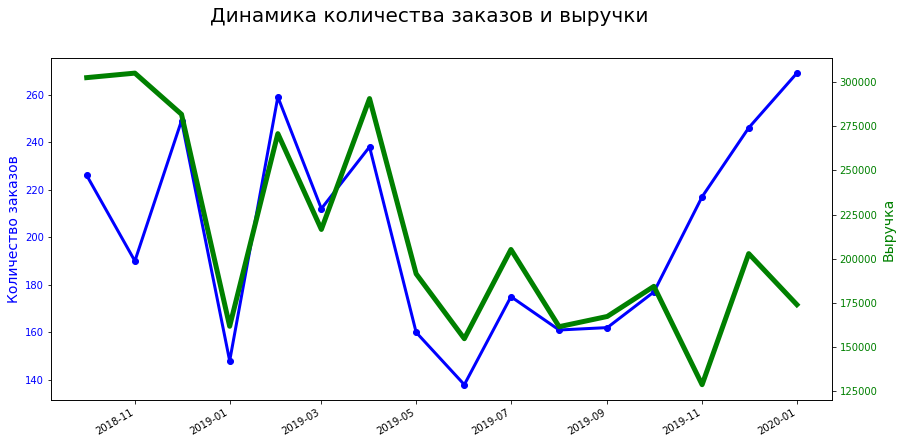

In [25]:
# визуализация динамки количества заказов и выручки
fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()

# количество уникальных заказов в месяц
ax1.plot(dt_clean_data.resample('MS')['order_id'].nunique(), color='blue', lw=3, marker='o')
# сумма всех позиций в заказах в месяц (выручка)
ax2.plot(dt_clean_data.resample('MS')['total'].sum(), color='green', lw=5);

# оформление графика
ax1.set_ylabel("Количество заказов", color='blue', fontsize=14)
ax1.tick_params(axis="y", labelcolor='blue')

ax2.set_ylabel("Выручка", color='green', fontsize=14)
ax2.tick_params(axis="y", labelcolor='green')

fig.suptitle("Динамика количества заказов и выручки", fontsize=20)
fig.autofmt_xdate()

In [26]:
print('Коэффициент корреляции кол-ва заказов и выручки по месяцам:',
round(dt_clean_data.resample('MS')['order_id'].nunique().corr(dt_clean_data.resample('MS')['total'].sum()), 2))

Коэффициент корреляции кол-ва заказов и выручки по месяцам: 0.49


**Корреляция:**
- Выручка и количество заказов имеют значительную положительную корреляцию, особенно отчетливо это видно с декабря 2018 по октябрь 2019 (линии повторяют динамику друг друга).

**Выручка:**  
- Динамика выуручки после апреля 2019 начала резко ухудшаться, во все последующие месяцы она не превышала 210 тыс.руб.
- Лучшим периодом по выручке был октябрь-декабрь 2018 года. Худшим - август-ноябрь 2019.

**Количество заказов:**
- Количество заказов имеет схожую динамику с выручкой и также просело в мае-сентябре 2019, но в отличии от выручки, с октябяря 2019 начало резко расти и к концу января 2020 достигло рекордных 269 заказов за месяц, однако положительного влияния на выручку это не оказало. Что можно интерпретировать как появление большего количества дешевых заказов.

---

### Динамика средней стоимости заказа

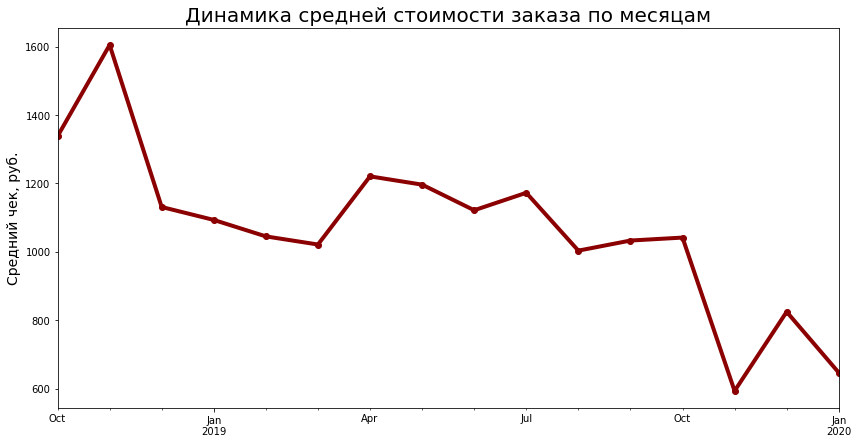

In [27]:
#расчет стоимости заказа
orders_list = clean_data.groupby(['date','order_id'], as_index=False)['total'].sum()
dt_orders_list = orders_list.set_index('date')

#визуализация по месяцам
dt_orders_list.resample('MS')['total'].mean().plot(figsize=(14, 7), lw=4, marker='o', color='darkred')
plt.ylabel('Средний чек, руб.', fontsize=14)
plt.xlabel('')
plt.title('Динамика средней стоимости заказа по месяцам', fontsize=20)
plt.show()

- Средний чек заказа значительно снизился за исследуемый период, **с 1400-1600 руб.** в окт-нояб 2018 года **до 600-800 руб** в нояб-дек 2019. 


- Отуствие корреляции выручки и количества заказов в октябре-ноябре 2018 вызвана высоким средним чеком, а в ноябре 2019 - январе 2020 - значительным понижением среднего чека. В остальной период корреляция была крайне положительной из-за стабильной динамики среднего чека, который находился **в диапазоне 1000-1200 руб**.

---

### Исследование пользователей

In [28]:
print('Количество уникальных пользователей за весь период:',
clean_data['customer_id'].nunique())

Количество уникальных пользователей за весь период: 2177


In [29]:
print('Количество уникальных заказов за весь период:',
clean_data['order_id'].nunique())

Количество уникальных заказов за весь период: 3227


In [30]:
# ТОП 10 пользователей по количеству заказов за весь период исследования
top10_users = clean_data.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False).head(10)
display(top10_users)

print('Среднее количество заказов на пользователя:',
round(clean_data.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False).mean(), 2))

print('Медианное количество заказов на пользователя:',
round(clean_data.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False).median(), 2))


customer_id
c971fb21-d54c-4134-938f-16b62ee86d3b    125
4d93d3f6-8b24-403b-a74b-f5173e40d7db     34
73d1cd35-5e5f-4629-8cf2-3fda829d4e58     16
b7b865ab-0735-407f-8d0c-31f74d2806cc      7
bea7a833-2074-42db-bc49-4457abd3c930      4
e0535076-6270-4df2-8621-cb06264a94fa      4
498f12a4-6a62-4725-8516-cf5dc9ab8a3a      4
d16fbc13-50a6-4dea-aafc-bc197aafc9e4      3
6b0c6cfb-7717-4c34-8535-bbc6e2b2c758      3
f163e581-59ba-4022-99db-e0973c7497c0      3
Name: order_id, dtype: int64

Среднее количество заказов на пользователя: 1.48
Медианное количество заказов на пользователя: 1.0


- Присутствют несколько аномальных пользователей, особенно необычный пользователь с 125 заказами. Из-за которого происходит значительное смещение среднего количества заказов на пользователей по всей выборке, которое равно 1.48, при медиане 1.00.

Стоит посмотреть на распределение пользователей по количеству заказов, устранив аномальных пользователей (3 пользователя с 16, 34 и 125 заказами).

In [31]:
# убираем аномально активных пользователей
dt_clean_data_upd = dt_clean_data.query('customer_id not in @top10_users.head(3).index')

In [32]:
print('Очищенные данные: среднее количество заказов на пользователя:',
round(dt_clean_data_upd.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False).mean(), 2))

Очищенные данные: среднее количество заказов на пользователя: 1.4


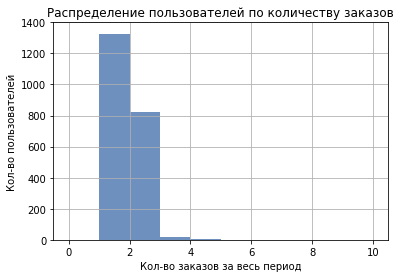

In [33]:
# распределение пользователей по количеству заказов
clean_data.groupby('customer_id')['order_id'].nunique().hist(range=(0,10))
plt.title('Распределение пользователей по количеству заказов')
plt.ylabel('Кол-во пользователей')
plt.ylim([0, 1400])
plt.xlabel('Кол-во заказов за весь период')
plt.show()

- Около 1300 пользовтелей (около 60% от всех) сделали только один заказ за весь период (1 год и 4 месяца).
- Около 800 пользовтелей ( около 37% от всех) сделали два заказа за весь период (1 год и 4 месяца).
- Т.е. только 3% пользователей сделали 3 и более заказов, что говорит либо о невысоком удержании покупателей, либо о крайне низкой частотности покупок товаров продающихся в магазине.

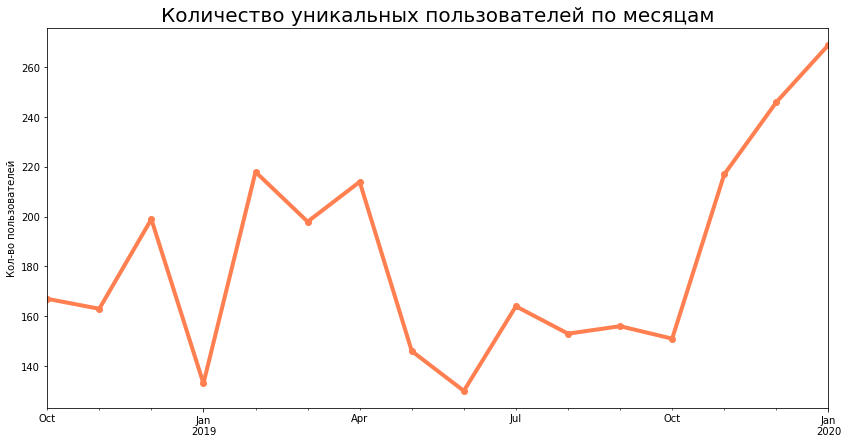

In [34]:
# количество уникальных пользователей по месяцам
dt_clean_data_upd.resample('MS')['customer_id'].nunique().plot(figsize=(14, 7), lw=4, marker='o', color='coral')
plt.title('Количество уникальных пользователей по месяцам', fontsize=20)
plt.ylabel('Кол-во пользователей')
plt.xlabel('')
plt.show()

- Количество уникальных пользователей **проседало в янв 2019 и в период с мая по октябрь 2019**. 
- В **последние 3 месяца периода заметен значительный рост** уникальных пользователей
- Динамика и абсолютные значения уникальных пользователей сильно похожа на динамику числа заказов, что скорее всего говорит о том, что пользователи не делают много заказов за один месяц. 

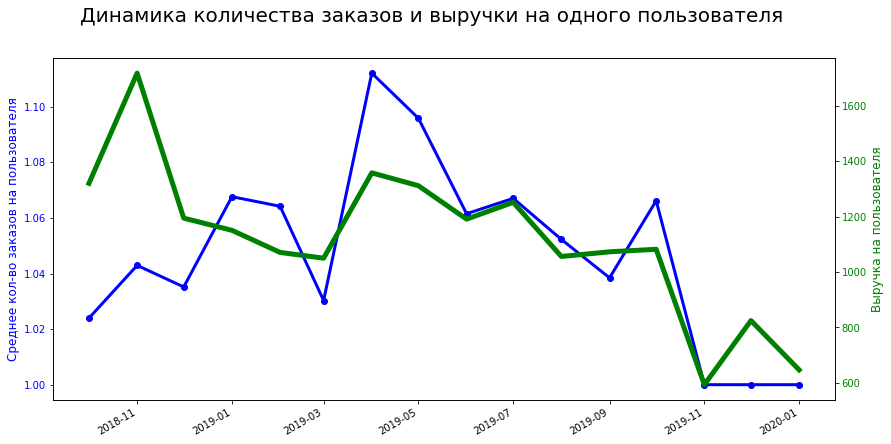

In [35]:
# визуализация динамки количества заказов и выручки на пользователя
fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()

# количество заказов на одного уникального пользователя в месяц
ax1.plot((dt_clean_data_upd.resample('MS')['order_id'].nunique() 
 / dt_clean_data_upd.resample('MS')['customer_id'].nunique()), color='blue', lw=3, marker='o')
# выручка на одного уникального пользователя в месяц
ax2.plot((dt_clean_data_upd.resample('MS')['total'].sum() 
 / dt_clean_data_upd.resample('MS')['customer_id'].nunique()), color='green', lw=5);

# оформление графика
ax1.set_ylabel("Среднее кол-во заказов на пользователя", color='blue', fontsize=12)
ax1.tick_params(axis="y", labelcolor='blue')

ax2.set_ylabel("Выручка на пользователя", color='green', fontsize=12)
ax2.tick_params(axis="y", labelcolor='green')

fig.suptitle("Динамика количества заказов и выручки на одного пользователя", fontsize=20)
fig.autofmt_xdate()

- Пользователи крайне редко делают более 2-ух заказов за один месяц. Максимальный показатель был в апреле 2019 - 1.08 (т.е. 100 уникальных пользователей сделали сумарно 108 заказов)
- В период с ноября 2019 по январь 2020 на каждого пользователя приходился ровно один заказ.
- Выручка на одного пользователя практически повторяет негативную динамику среднего чека, т.к. пользователи обычно делают один заказ в месяц.

### Итоговый вывод по исследовательскому анализу

---

- Были обнаружены и удалены аномальные записи по количеству товаров и по стоимости позиции.


- Онлайн-магазин имеет **снижающуюся динамику выручки при стабильном и даже растущем количестве заказов и пользователей**. Причиной этому крайне негативная динамика **среднего чека, который упал примерно в два раза** с 1400-1600 руб. в окт-нояб 2018 года до 600-800 руб в нояб-дек 2019. 


- Около 1300 пользовтелей (около 60% от всех) сделали только один заказ и около 800 пользовтелей (около 37% от всех) сделали два заказа за весь период (1 год и 4 месяца). Т.е. только 3% пользователей сделали 3 и более заказов. 


- Среднее количество заказов на одного пользователя за весь период (1 год и 4 месяца) составляет 1.4, что говорит о **очень низкой частотности совершения покупок** и возможно о низком удержании покупателей.


- Пользователи **крайне редко делают более 2-ух заказов за один месяц**. Диапазон среднего количество заказов на одного пользователя в месяц равен от 1.00 до 1.08, что подтверждает низкую частотность совершения покупок.


- Выручка на одного пользователя практически **повторяет негативную динамику среднего чека**, т.к. пользователи обычно делают один заказ в месяц.

---

## Проведение анализа ассортимента

**Задачи по анализу ассортимента:**
- Формирование категорий и распределение товаров по ним
- ABC анализ: распределние товаров по категориям исходя из двух критериев: выручка и количество продаж
- Изучить динамику выручки по категориям товаров

### Формирование категорий товаров

In [36]:
print('Количество уникальных наименований товаров:',
clean_data['product'].nunique())

Количество уникальных наименований товаров: 2196


In [37]:
clean_data['product'].value_counts().head(10)

Пеларгония розебудная Red Pandora укорененный черенок                 59
Пеларгония зональная диам. 12 см сиреневый полумахровый               49
Пеларгония розебудная Prins Nikolai укорененный черенок               49
Сумка-тележка 2-х колесная Gimi Argo синяя                            39
Пеларгония розебудная Mary укорененный черенок                        38
Пеларгония розебудная Queen Ingrid укорененный черенок                29
Пеларгония розебудная Margaretha укорененный черенок                  27
Пеларгония зональная махровая лососевая                               25
Пеларгония зональная диам. 12 см коралловая полумахровая              24
Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок    23
Name: product, dtype: int64

In [38]:
# проведем лемматизацию в наименовании товара и сохраним в новый столбец
m = Mystem()
clean_data['lemmas'] = clean_data['product'].apply(m.lemmatize)

In [39]:
# посчитаем самые частотные леммы
lemmas = Counter(clean_data['lemmas'].sum()).most_common()
lemmas

[(' ', 32092),
 ('\n', 4983),
 ('см', 2212),
 ('-', 2009),
 (', ', 2005),
 ('для', 1060),
 ('пеларгония', 799),
 (',', 604),
 ('рассада', 582),
 ('в', 557),
 ('л', 492),
 ('зональный', 474),
 ('12', 468),
 ('. ', 462),
 ('d', 455),
 ('диам', 442),
 ('с', 440),
 ('5', 390),
 ('кассета', 388),
 (' (', 385),
 ('сорт', 375),
 ('шт', 369),
 ('0', 358),
 ('тележка', 353),
 ('белый', 332),
 (') ', 330),
 ('9', 326),
 ('белье', 326),
 ('сумка', 323),
 ('красный', 322),
 ('черенок', 318),
 ('укоренять', 316),
 ('махровый', 310),
 ('горшок', 290),
 ('сушилка', 288),
 ('2', 269),
 ('объем', 265),
 ('цветок', 265),
 ('доска', 246),
 ('по', 244),
 ('6', 235),
 ('розебудный', 230),
 ('10', 220),
 ('/', 208),
 ('кухня', 208),
 ('гладильный', 204),
 ('синий', 202),
 ('зелень', 202),
 ('Gimi', 200),
 ('розовый', 198),
 ('томат', 188),
 ('4', 187),
 ('однолетний', 187),
 ('7', 186),
 ('1', 180),
 ('полумахровый', 179),
 ('петуния', 179),
 ('помидор', 178),
 ('№', 177),
 ('россия', 175),
 ('и', 172),
 ('

In [40]:
# функция для формирования категорий товаров
def lemmas_category(lemmas):
    if ('гладильный' in lemmas) or ('сушилка' in lemmas) or\
    ('одежда' in lemmas) or ('вешалка' in lemmas) or\
    ('подкладка' in lemmas) or ('подрукавник' in lemmas) or\
    ('обувь' in lemmas) or ('плечики' in lemmas) or\
    ('одежный' in lemmas) or ('обувной' in lemmas):
        return 'Для одежды и обуви'
    if ('пружина' in lemmas) or ('петля' in lemmas) or\
    ('проволочный' in lemmas) or ('инструмент' in lemmas) or\
    ('стремянка' in lemmas) or ('корыто' in lemmas) or\
    ('цинк' in lemmas) or ('строительный' in lemmas) or\
    ('сверло' in lemmas) or ('сварка' in lemmas) or ('стяжка' in lemmas) or\
    ('набор' in lemmas) or ('измерительный' in lemmas) or\
    ('длина' in lemmas) or ('батарейка' in lemmas) or\
    ('бензин' in lemmas) or ('шило' in lemmas) or\
    ('сметка' in lemmas) or ('уличный' in lemmas) or ('веревка' in lemmas):
        return 'Стройка и ремонт'
    if ('кружка' in lemmas) or ('лоток' in lemmas) or\
    ('сковорода' in lemmas) or ('сотейник' in lemmas) or ('салатник' in lemmas) or\
    ('кастрюля' in lemmas) or ('котел' in lemmas) or\
    ('овощеварка' in lemmas) or ('мантоварка' in lemmas) or\
    ('соковарка' in lemmas) or ('миска' in lemmas) or\
    ('противень' in lemmas) or ('нож' in lemmas) or\
    ('столовая' in lemmas) or ('столовый' in lemmas) or\
    ('чайный' in lemmas) or ('терка' in lemmas) or\
    ('толкушка' in lemmas) or ('тарелка' in lemmas) or\
    ('термокружок' in lemmas) or ('свч' in lemmas) or\
    ('ложка' in lemmas) or ('банка' in lemmas) or\
    ('крышка' in lemmas) or ('пищевой' in lemmas) or\
    ('овощ' in lemmas) or ('венчик' in lemmas) or\
    ('хлебница' in lemmas) or ('рыбочистка' in lemmas) or\
    ('бокал' in lemmas) or ('фужер' in lemmas) or\
    ('чайный' in lemmas) or ('форма' in lemmas) or\
    ('картофелемялка' in lemmas) or ('ножеточка' in lemmas) or\
    ('бутылка' in lemmas) or ('стакан' in lemmas) or\
    ('лезвие' in lemmas) or ('лопатка' in lemmas) or\
    ('ковш' in lemmas) or ('разделочный' in lemmas) or\
    ('термос' in lemmas) or ('сито' in lemmas) or\
    ('плита' in lemmas) or ('пресс' in lemmas):
        return 'Посуда'
    if ('чайник' in lemmas) and ('эмалированный' in lemmas) or ('заварочный' in lemmas):
        return 'Посуда'
    if ('покрывало' in lemmas) or ('хлопок' in lemmas) or\
    ('салфетка' in lemmas) or ('одеяло' in lemmas) or\
    ('полотенце' in lemmas) or ('подушка' in lemmas) or\
    ('скатерть' in lemmas) or ('плед' in lemmas) or ('халат' in lemmas):
        return 'Текстиль'
    if ('электрический' in lemmas) or ('миксер' in lemmas) or\
    ('фен' in lemmas) or ('паровой' in lemmas) or\
    ('пылесос' in lemmas) or ('весы' in lemmas) or\
    ('светильник' in lemmas):
        return 'Бытовая техника'
    if ('сумка' in lemmas) or ('тележка' in lemmas) or\
    ('кофр' in lemmas) or ('хранение' in lemmas) or\
    ('ящик' in lemmas) or ('коробка' in lemmas) or\
    ('корзина' in lemmas) or ('контейнер' in lemmas) or\
    ('таз' in lemmas) or ('полка' in lemmas) or ('комод' in lemmas):
        return 'Хранение и перемещение'
    if ('цветок' in lemmas) and ('искусственный' in lemmas) or\
    ('композиция' in lemmas) or ('подарочный' in lemmas) or\
    ('открытка' in lemmas) or ('упаковка' in lemmas) or\
    ('новогодний' in lemmas) or ('картина' in lemmas) or\
    ('фотография' in lemmas) or ('муляж' in lemmas):
        return 'Декор, искусственные цветы и подарки'
    if ('рассада' in lemmas) and ('зелень' in lemmas) or ('томат' in lemmas) or\
    ('капуста' in lemmas) or ('перец' in lemmas) or ('огурец' in lemmas) or\
    ('тыква' in lemmas) or ('кабачок' in lemmas) or\
    ('клубника' in lemmas) or ('арбуз' in lemmas) or\
    ('дыня' in lemmas) or ('патиссон' in lemmas) or\
    ('баклажан' in lemmas) or ('земляника' in lemmas) or\
    ('морковь' in lemmas) or ('петрушка' in lemmas) or\
    ('пряный' in lemmas) or ('лекарственный' in lemmas):
        return 'Рассада овощей, фруктов и зелени'
    if ('d' in lemmas) and ('вантуз' in lemmas) or\
    ('d' in lemmas) and ('щетка' in lemmas) or\
    ('d' in lemmas) and ('чехол' in lemmas) or\
    ('d' in lemmas) and ('коврик' in lemmas) or\
    ('d' in lemmas) and ('средство' in lemmas):
        return 'Для чистоты и уборки'
    if ('цветок' in lemmas) and ('рассада' in lemmas) or\
    ('однолетний' in lemmas) or ('многолетний' in lemmas) or\
    ('петуния' in lemmas) or ('черенок' in lemmas) or ('крупноцветковый' in lemmas) or\
    ('цвести' in lemmas) or ('садовый' in lemmas) or ('объем' in lemmas) or\
    ('растение' in lemmas) and ('комнатный' in lemmas) or\
    ('домашний' in lemmas) or ('горшок' in lemmas) or\
    ('кашпо' in lemmas) or ('пеларгония' in lemmas) or ('d' in lemmas): 
        return 'Комнатные растения и рассада садовых цветов'
    if 'кассета' in lemmas:
        return 'Рассада овощей, фруктов и зелени'
    if ('ванный' in lemmas) or ('ванна' in lemmas) or ('ванная' in lemmas) or\
    ('туалет' in lemmas) or ('туалетный' in lemmas) or\
    ('унитазный' in lemmas) or ('унитаз' in lemmas) or\
    ('белье' in lemmas) or ('стиральный' in lemmas) or\
    ('коврик' in lemmas) or ('ковер' in lemmas) or ('вантуз' in lemmas) or\
    ('посуда' in lemmas) or ('мытье' in lemmas) or ('чистка' in lemmas) or\
    ('щетка' in lemmas) or ('мыло' in lemmas) or ('швабра' in lemmas) or\
    ('зубной' in lemmas) or ('кухонный' in lemmas) or\
    ('круглый' in lemmas) or ('чистить' in lemmas) or\
    ('перчатка' in lemmas) or ('деревянный' in lemmas) or\
    ('тряпка' in lemmas) or ('скребок' in lemmas) or\
    ('ведро' in lemmas) or ('карниз' in lemmas) or\
    ('совок' in lemmas) or ('губка' in lemmas) or\
    ('антижир' in lemmas) or ('кольцо') or\
    ('мл' in lemmas) or ('чехол' in lemmas) or\
    ('придверный' in lemmas) or ('средство' in lemmas):
        return 'Для чистоты и уборки'
    else:
        return NaN

**Составлены 10 категорий товаров:**
- Комнатные растения и рассада садовых цветов
- Для чистоты и уборки
- Для одежды и обуви
- Хранение и перемещение
- Стройка и ремонт
- Декор, искусственные цветы и подарки
- Рассада овощей, фруктов и зелени
- Посуда
- Текстиль
- Бытовая техника

In [41]:
# столбец с категориями
clean_data['product_category'] = clean_data['lemmas'].apply(lemmas_category)
# удаление столбца с леммами
clean_data.drop(columns='lemmas', inplace=True)

In [42]:
clean_data.head(15)

,date,customer_id,order_id,product,quantity,price,total,product_category
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,Комнатные растения и рассада садовых цветов
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,Комнатные растения и рассада садовых цветов
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,Комнатные растения и рассада садовых цветов
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,Комнатные растения и рассада садовых цветов
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,Комнатные растения и рассада садовых цветов
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,164.0,Комнатные растения и рассада садовых цветов
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,134.0,Комнатные растения и рассада садовых цветов
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,824.0,Для одежды и обуви
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0,269.0,Хранение и перемещение
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0,674.0,Для одежды и обуви


In [43]:
# проверка нераспределенных товаров
clean_data['product_category'].isna().sum()

0

### ABC анализ ассортимента по категориям

In [44]:
# выручка и количество проданных товаров по категориям
сategory_table = round(clean_data.groupby('product_category').agg({'total' :'sum', 'quantity' :'sum'})
      .sort_values(by='total', ascending=False))
сategory_table.columns = ['revenue', 'quantity_sold']
сategory_table['revenue_share'] = round(сategory_table['revenue'] / сategory_table['revenue'].sum(),2)
сategory_table['quantity_share'] = round(сategory_table['quantity_sold'] / сategory_table['quantity_sold'].sum(),2)
сategory_table

,revenue,quantity_sold,revenue_share,quantity_share
product_category,,,,
Хранение и перемещение,904433.0,529,0.27,0.05
Для одежды и обуви,772890.0,1156,0.23,0.11
Для чистоты и уборки,470578.0,1357,0.14,0.13
Комнатные растения и рассада садовых цветов,387529.0,2264,0.11,0.22
Стройка и ремонт,233568.0,815,0.07,0.08
Посуда,222736.0,1146,0.07,0.11
Текстиль,190154.0,305,0.06,0.03
"Декор, искусственные цветы и подарки",102479.0,1724,0.03,0.17
"Рассада овощей, фруктов и зелени",76708.0,1020,0.02,0.10


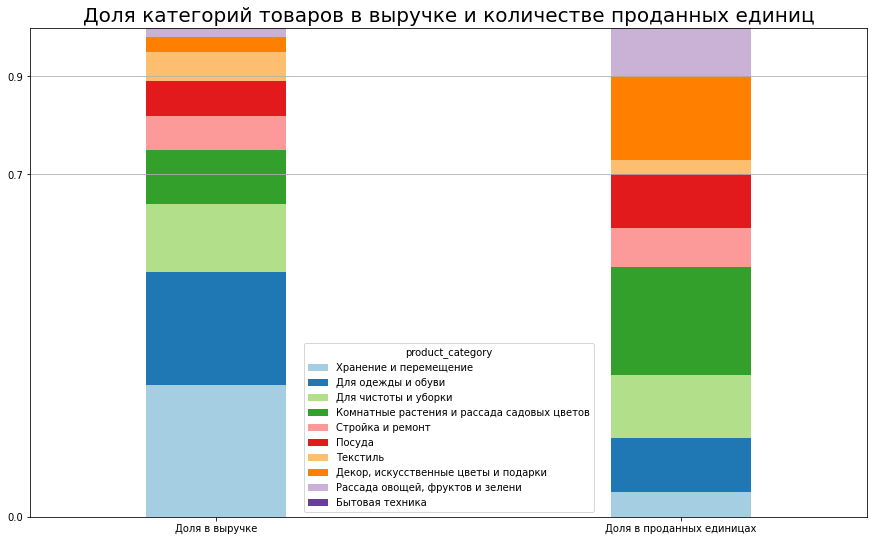

In [45]:
sns.set_palette('Paired')
сategory_table.transpose()[2:4].plot.bar(stacked=True, figsize=(15,9), width=0.3).grid(axis='y')
plt.ylim(ymax = 1)
plt.yticks([0, 0.7, 0.9])
plt.title("Доля категорий товаров в выручке и количестве проданных единиц", fontsize=20)
plt.xticks([0, 1], ['Доля в выручке', 'Доля в проданных единицах'], rotation=0);

- По таблице и графику видно, что некоторые категории, которые приносят значительную часть прибыли, занимают небольшую долю в количестве проданных товаров. Например **категория "Хранение и перемещение", куда входят сумки и тележки занимает 27% от выручки, но 5% в количестве проданных единиц**, что говорит о высоких ценах на товары  и штучном характере продаж в данной категории.


- Есть и обратная ситуация - категория **"Декор, искусственные цветы и подарки" занимает только 3% выручки, а в количестве проданных единиц целых 17%**, что говорит о дешевых ценах и массовости товаров в данной категории.

In [46]:
# расчитаем среднюю стоимость товаров по категориям
avg_price = clean_data.groupby('product_category')['price'].mean().sort_values(ascending=False)

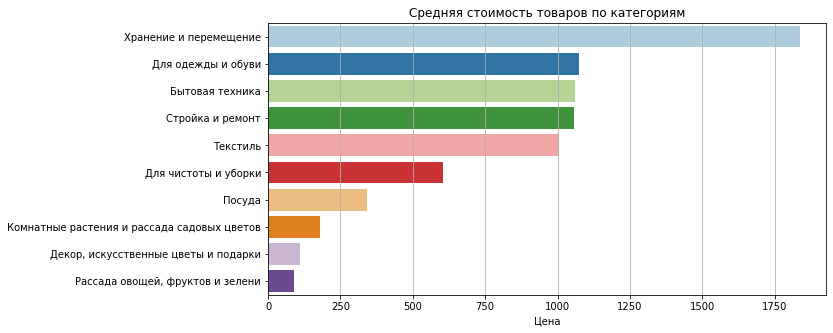

In [47]:
plt.figure(figsize=(10,5))
sns.barplot(y=avg_price.index, x=avg_price)
plt.grid(axis='x')
plt.xlabel('Цена')
plt.ylabel('')
plt.title('Средняя стоимость товаров по категориям')
plt.show()

- Как и ожидалось, товары из категории **"Хранение и перемещение"** имеют самую высокую среднюю цену - около 1800 руб.
- Со значительным отрывом отстают категории "Для одежды и обуви", "Бытовая техника", "Стройка и ремонт" и "Текстиль" со средней ценой в диапазоне 1000 - 1100 руб.
- Самые дешевые товары в категориях с рассадой и комнатными растениями, а так же "Декор, искусственные цветы и подарки".

---

Для того чтобы определить вклад каждой категории в продажи магазина следует присвоить им рейтинги по двум параметрам **выручка и количество продаж**:
- **Рейтинг А:** наибольшие доли по выручке/продажам, кумулятивно составляющие до **70%** от оборота
- **Рейтинг B:** средние доли по выручке/продажам, кумулятивно составляющие **20%** (от 70% до 90% от оборота - остаток)
- **Рейтинг С:** наименьшие доли по выручке/продажам, кумулятивно составляющие **10%** (от 90% до 100% от оборота - остаток)

In [48]:
# составим функцию для создания списка с рейтингом по нужному параметру
def ABC_classification(share_type, table):
    rating = []
    cumulative = 0
    for x in table[share_type].sort_values(ascending=False):
        if cumulative < 0.7:
            cumulative += x
            rating.append('A')    
        elif cumulative < 0.9:
            cumulative += x
            rating.append('B')
        else:
            rating.append('C')
    return rating

In [49]:
# получившийся список передаем в соответствующий столбец таблицы
сategory_table['revenue_rating'] = ABC_classification('revenue_share', сategory_table)

In [50]:
# выполняем сортировку по второму параметру (количеству) для передачи второго списка в столбец
сategory_table = сategory_table.sort_values(by='quantity_share', ascending=False)

In [51]:
# получившийся список передаем в соответствующий столбец таблицы
сategory_table['quantity_rating'] = ABC_classification('quantity_share', сategory_table)

In [52]:
# сортируем категории по обоим рейтингам 
сategory_table.sort_values(by=['revenue_rating', 'quantity_rating'])

,revenue,quantity_sold,revenue_share,quantity_share,revenue_rating,quantity_rating
product_category,,,,,,
Комнатные растения и рассада садовых цветов,387529.0,2264,0.11,0.22,A,A
Для чистоты и уборки,470578.0,1357,0.14,0.13,A,A
Для одежды и обуви,772890.0,1156,0.23,0.11,A,A
Хранение и перемещение,904433.0,529,0.27,0.05,A,C
Посуда,222736.0,1146,0.07,0.11,B,A
Стройка и ремонт,233568.0,815,0.07,0.08,B,B
Текстиль,190154.0,305,0.06,0.03,B,C
"Декор, искусственные цветы и подарки",102479.0,1724,0.03,0.17,C,A
"Рассада овощей, фруктов и зелени",76708.0,1020,0.02,0.10,C,B


**Категории с рейтингом АА и AC (штучные дорогие товары):**  
**|**Товары для одежды и обуви **|** Товары для чистоты и уборки **|** Комнатные растения и рассада садовых цветов **|** Хранение и перемещение **|**  
*Товары-лидеры, категория наивысшего приоритета, товары постоянно должны быть в наличии, необходим тщательный контроль уровня запасов*


**Категории с рейтингом BA, BB и BC:**  
**|** Посуда  **|**  Стройка и ремонт  **|**  Текстиль **|**  
*Товары-середнячки, средний уровень управления запасами и размещением на полках*

**Категории с рейтингом CA, CB и CC:**  
**|** Декор, искусственные цветы и подарки  **|**  Рассада овощей, фруктов и зелени  **|**  Бытовая техника	 **|**  
*Товары-аутсайдеры, необходим детальный анализ категории и выведение из ассортимента самых низкоэффективных товаров.*

---


### ABC анализ ассортимента по товарам

In [53]:
# создадим таблицу с выручкой и количеством продаж по всем товарам
revenue_and_quantity_by_product = clean_data.groupby('product', as_index=False).agg({'total':'sum', 'quantity' : 'sum'}) \
.sort_values(by='total', ascending=False)

revenue_and_quantity_by_product.columns = ['product', 'revenue', 'quantity_sold']
revenue_and_quantity_by_product['revenue_share'] = round(revenue_and_quantity_by_product['revenue'] \
                                                   / revenue_and_quantity_by_product['revenue'].sum(),4) 
revenue_and_quantity_by_product['quantity_share'] = round(revenue_and_quantity_by_product['quantity_sold'] \
                                                   / revenue_and_quantity_by_product['quantity_sold'].sum(),4)

revenue_and_quantity_by_product.head(10)

,product,revenue,quantity_sold,revenue_share,quantity_share
1511,Сумка-тележка 2-х колесная Gimi Argo синяя,41861.0,39,0.0123,0.0038
1594,Сушилка Meliconi Stendy Junior,27970.0,5,0.0082,0.0005
767,Мусорный контейнер Hailo BigBin Swing 45 0845-...,27560.0,5,0.0081,0.0005
1828,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см...",24370.0,5,0.0072,0.0005
1565,Сумка-тележка хозяйственная Rolser IMX006 bass...,23037.0,3,0.0068,0.0003
1537,Сумка-тележка хозяйственная Andersen Scala Sho...,22796.0,4,0.0067,0.0004
116,"Веник сорго с деревянной ручкой с 4-мя швами, ...",20550.0,38,0.0060,0.0037
1520,Сумка-тележка 2-х колесная складная Gimi Flexi...,19788.0,12,0.0058,0.0012
1585,Сумка-тележка хозяйственная Rolser Pack Gloria...,19674.0,3,0.0058,0.0003
1522,Сумка-тележка 3-х колесная Gimi Tris Floral синяя,18893.0,7,0.0056,0.0007


- Наибольшую выручку принесла **"Сумка-тележка 2-х колесная Gimi Argo синяя"**.
- **6 из ТОП 10 позиций** входят в самую крупную категорию по выручке **"Хранение и перемещение"**, что логично.

---

Проведем ABC категоризацию по товарам по таким же параметрам как с категориями товаров **70/20/10**.

In [54]:
# получившийся список передаем в соответствующий столбец таблицы
revenue_and_quantity_by_product['revenue_rating'] = ABC_classification('revenue_share', revenue_and_quantity_by_product)

In [55]:
# выполняем сортировку по второму параметру (количеству) для передачи второго списка в столбец
revenue_and_quantity_by_product = revenue_and_quantity_by_product.sort_values(by='quantity_share', ascending=False)

In [56]:
# получившийся список передаем в соответствующий столбец таблицы
revenue_and_quantity_by_product['quantity_rating'] = ABC_classification('quantity_share', revenue_and_quantity_by_product)

In [57]:
# сортируем товары по обоим рейтингам 
revenue_and_quantity_by_product.sort_values(by=['revenue_rating', 'quantity_rating']).head(10)

,product,revenue,quantity_sold,revenue_share,quantity_share,revenue_rating,quantity_rating
764,Муляж Яблоко зеленый 9 см полиуретан,8132.0,148,0.0024,0.0143,A,A
708,Муляж Банан желтый 21 см полиуретан,5772.0,108,0.0017,0.0104,A,A
2099,Щетка-сметка 4-х рядная деревянная 300 мм (фиг...,6810.0,105,0.0020,0.0101,A,A
2089,"Щетка для посуды *ОЛЯ*, Мультипласт 1807010",2626.0,101,0.0008,0.0098,A,A
2035,"Шпингалет 80 мм белый с пружиной, 1102188",4400.0,100,0.0013,0.0097,A,A
2088,Щетка для мытья посуды КОЛИБРИ М5202 большая,3400.0,100,0.0010,0.0097,A,A
618,Крючок одежный 2-х рожковый серый металлик с п...,3648.0,96,0.0011,0.0093,A,A
735,Муляж Лимон желтый 9 см полиуретан,4998.0,92,0.0015,0.0089,A,A
968,"Петля приварная гаражная d 14х90 мм с шаром, 1...",3420.0,90,0.0010,0.0087,A,A
7,"Ёрш унитазный с деревянной ручкой , Ваир 1712012",4513.0,83,0.0013,0.0080,A,A


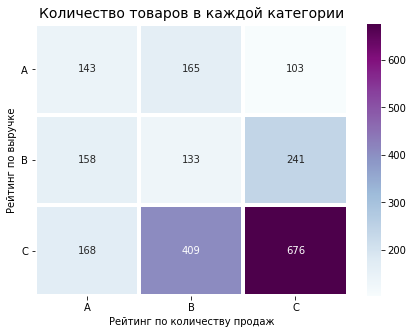

In [58]:
# построим хитмап для количества товаров в каждой ABC категории
products_count_pivot = revenue_and_quantity_by_product.pivot_table(
    index='revenue_rating', columns='quantity_rating', values='product', aggfunc='count')

plt.figure(figsize=(7, 5))

sns.heatmap(products_count_pivot, annot=True, fmt='.0f', linewidth=3, cmap='BuPu')
plt.title('Количество товаров в каждой категории', fontsize=14)
plt.yticks(rotation=0)
plt.xlabel('Рейтинг по количеству продаж')
plt.ylabel('Рейтинг по выручке');

- Большая часть товаров находится в категории СС (676). Так же многочисленны категории СB (409) и ВС (241). Получается, что большая часть товаров находятся в слабых категориях, в то время как в АА только 143 товара из 2196.  

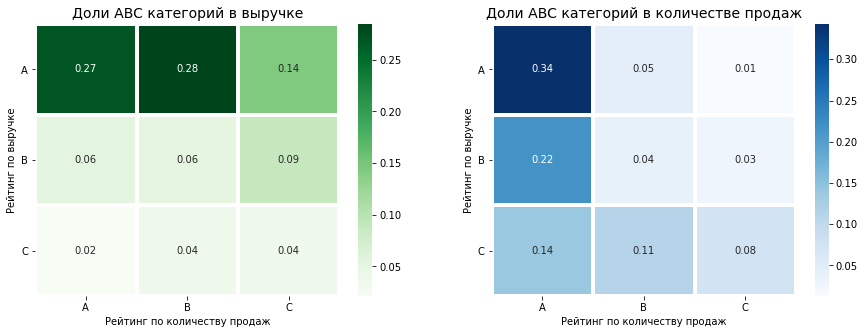

In [59]:
# построим хитмапы для доли ABC катгерий в выручке и количестве продаж
rev_pivot = revenue_and_quantity_by_product.pivot_table(
    index='revenue_rating', columns='quantity_rating', values='revenue_share', aggfunc='sum')

qnty_pivot = revenue_and_quantity_by_product.pivot_table(
    index='revenue_rating', columns='quantity_rating', values='quantity_share', aggfunc='sum')

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15, 5))
sns.heatmap(rev_pivot, annot=True, fmt='.2f', linewidth=3, cmap='Greens', ax=ax1)
ax1.set_title('Доли ABC категорий в выручке', fontsize=14)
ax1.tick_params(labelrotation=0)
ax1.set_xlabel('Рейтинг по количеству продаж')
ax1.set_ylabel('Рейтинг по выручке')

sns.heatmap(qnty_pivot, annot=True, fmt='.2f', linewidth=3, cmap='Blues', ax=ax2)
ax2.set_title('Доли ABC категорий в количестве продаж', fontsize=14)
ax2.tick_params(labelrotation=0)
ax2.set_xlabel('Рейтинг по количеству продаж')
ax2.set_ylabel('Рейтинг по выручке');

- Из хитмапов видно, что **ядро и основа ассортимента это товары из категорий АА, АB и BA, также важна категория АС**, которая генерит 14% выручки, но в количестве составляет всего лишь 1% (это штучные дорогостоящие товары)

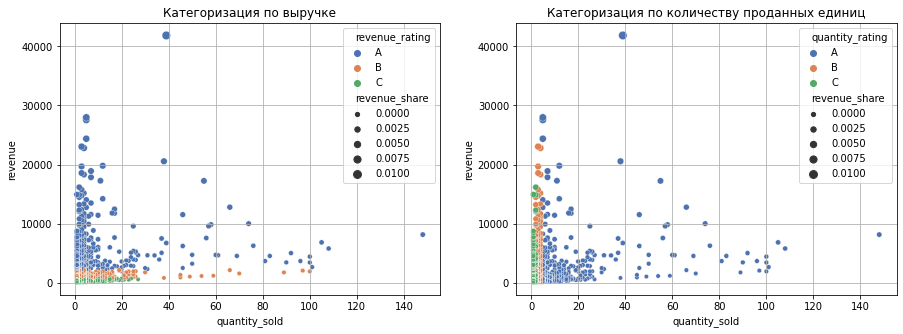

In [60]:
# распределение товаров по выручке и количеству проданных единиц
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15, 5))
sns.scatterplot(data=revenue_and_quantity_by_product,x='quantity_sold', y='revenue', hue='revenue_rating',
                size='revenue_share', palette='deep', ax=ax1)
ax1.set_title('Категоризация по выручке')
ax1.grid(True)
sns.scatterplot(data=revenue_and_quantity_by_product,x='quantity_sold', y='revenue', hue='quantity_rating',
                size='revenue_share', palette='deep', ax=ax2)
ax2.set_title('Категоризация по количеству проданных единиц')
ax2.grid(True)

- Большинство товаров находятся в квадрате - **до 10 тыс. руб по выручке и до 20 проданных единиц за период исследования.**
- Товары которые приносят больше всего выручки в основном не массовые.

### Динамика выручки по категориям товаров

In [61]:
# утсановим дату в качестве индекса для агрегирования данных по месяцам
dt_clean_data_upd = clean_data.set_index('date')

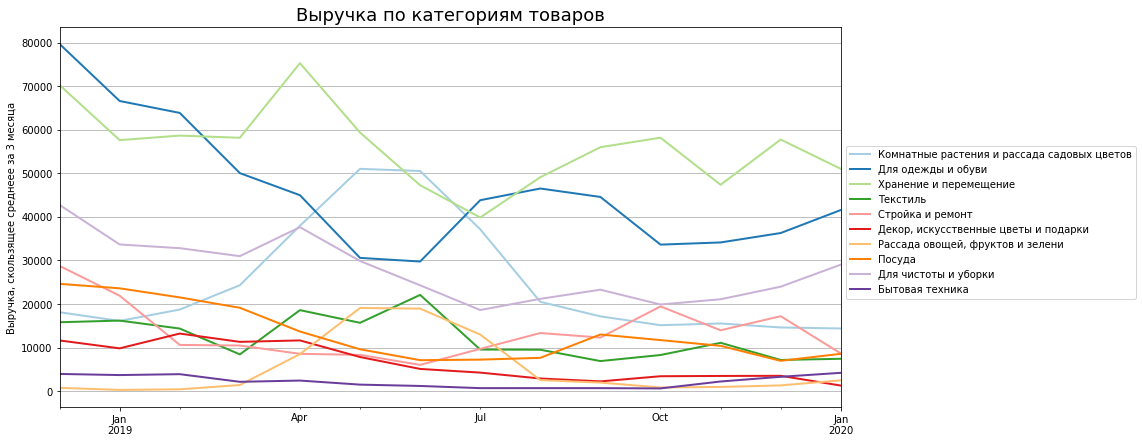

In [62]:
# визуализация выручки по категориям товаров (по месяцам)
for category in dt_clean_data_upd['product_category'].unique():
    dt_clean_data_upd.query('product_category == @category').resample('MS')['total'].sum().rolling(3).mean().plot(figsize=(14, 7), lw=2)
plt.legend(dt_clean_data_upd['product_category'].unique(), bbox_to_anchor=(1,0.7))
plt.title('Выручка по категориям товаров', fontsize=18)
plt.ylabel('Выручка, скользящее среднеее за 3 месяца')
plt.xlabel('')
plt.grid(axis='y')
plt.xlim('2018-12-01', '2020-01-01' );

- Категории **"Хранение и перемещение" и товары "Для одежды и обуви" являются лидерами по генерации выручки**. Их месячная выручка(скользящее среднее по 3 месяцам) не опускалась ниже 30 тыс. руб., а в начале 2019 даже находилась в диапозоне 60-80 тыс. руб.


- **Комнатные растения и рассада садовых цветов** имеют сезонный характер продаж, так виден всплеск продаж в конце весны - начале лета, до 50 тыс. руб. и даже выход в лидеры по выручке в июне 2019 года. Тот же тренд наблюдается у менее популярной категории **"Рассада овощей, фруктов и зелени"**.


- Динамика выручки по категориям схожа с динамикой общей выручки - **большинство категорий снизили месячную выручку** к концу исследуемого периода.

### Итоговый вывод по анализу ассортимента

- Категории товаров имеют разный характер - некоторые из них генерируют большую долю в выручке, но продаются в небольших количествах,например "Хранение и перемещение" *(27% выручки / 5% в количестве)*, и имеют высокую среднюю цену на товар (1800 руб). Другие продаются в больших количествах, но имеют мизерную долю в выручке, например "Декор, искусственные цветы и подарки"*(3% выручки / 17% в количестве)*, и имеют низкую среднюю цену на товар (110 руб).


- **Наиболее важными категориями**, по резултатам АBC анализа, признаны следющие категории:  
|Товары для одежды и обуви | Товары для чистоты и уборки | Комнатные растения и рассада садовых цветов | Хранение и перемещение |  
Это ядро и основной ассортимента магазина, генерирующее около 70% выручки.


- **Категории-аутсайдеры**, с низкими показателями, претендующие на исключение из ассортимента:  
| Декор, искусственные цветы и подарки | Рассада овощей, фруктов и зелени | Бытовая техника |  
Это дополнительные и незначительные категории, в сумме генерируют всего лишь около 6% выручки.


- Динамика выручки по категориям схожа с динамикой общей выручки - большинство категорий снизили месячную выручку к концу исследуемого периода. Для рассады и растений наблюдается повышенный сезон продаж, приходящийся на конец весны-начало лета.



**Рекомендации:**

- Cкорее всего негативная динамика выручки магазина связана с неоптимиальным ассортиментом, **необходимо выводить из ассортимента** товары из категории СС и частично из СB - они практически не приносят выручки и мало продаются.


- **Внимательно следить за наличием** товаров из категорий АА, АС. Это ядро и основа ассортимента, дающие большую часть выручки и продаж.


- **Повысить промо-активность** для товаров из категории AC. Это товары генерящие хорошую выручку, но продающиеся редко.


---


## Статистическая проверка различий еженедельной выручки и количества проданных товаров между двух групп категорий товаров

**Группы:**  
- **A.** Категории товаров с рейтингом А по выручке   
-  **B.** Категории товаров с рейтингом B по выручке

**Гипотеза 1**  
Нулевая : еженедельная выручка группы A равна еженедельной выручки группы B  
Альтернативная: еженедельная выручка группы A выше  

**Гипотеза 2**  
Нулевая : еженедельное количество проданных товаров группы A равна этому же показателю группы B  
Альтернативная: еженедельное количество проданных товаров группы A выше  

Уровень значимости : 5%

---

In [63]:
# формируем списки с категориями для групп А и B
group_A = сategory_table.query('revenue_rating == "A"').index
group_B = сategory_table.query('revenue_rating == "B"').index
display('Группа А', group_A)
display('Группа B',group_B)

'Группа А'

Index(['Комнатные растения и рассада садовых цветов', 'Для чистоты и уборки',
       'Для одежды и обуви', 'Хранение и перемещение'],
      dtype='object', name='product_category')

'Группа B'

Index(['Посуда', 'Стройка и ремонт', 'Текстиль'], dtype='object', name='product_category')

In [64]:
# формируем две выборки по двум группам
group_A_sample = dt_clean_data_upd.query('product_category in @group_A').resample('W-MON')['total'].sum()
group_B_sample = dt_clean_data_upd.query('product_category in @group_B').resample('W-MON')['total'].sum()

# выручка по неделям для обоих групп
revenue_table = round(pd.concat([group_A_sample, group_B_sample],axis=1, keys=['group_A', 'group_B']))
revenue_table

,group_A,group_B
date,,
2018-10-01,8074.0,187.0
2018-10-08,52858.0,29008.0
2018-10-15,52165.0,11932.0
2018-10-22,45479.0,12369.0
2018-10-29,50074.0,9188.0
...,...,...
2020-01-06,46774.0,4680.0
2020-01-13,34791.0,5904.0
2020-01-20,31470.0,6327.0


In [65]:
print('Средняя еженедельная выручка группы А:',round(revenue_table['group_A'].mean()))
print('Средняя еженедельная выручка группы B:',round(revenue_table['group_B'].mean()))

Средняя еженедельная выручка группы А: 35710
Средняя еженедельная выручка группы B: 9105


In [66]:
# расчет p-value и относительной разницы
print('P-value:',"{0:.7f}".format(stats.mannwhitneyu(group_A_sample, group_B_sample)[1]))
print('Относительная разница:', "{0:.3f}".format(group_B_sample.mean() / group_A_sample.mean() - 1))

P-value: 0.0000000
Относительная разница: -0.745


**Вывод по Гипотезе 1:**  
P-value значительно меньше 5%, поэтому следует отвергнуть нулевую гипотезу о равенстве метрик (еженедельная выручка).
Относительная разница показывает **отставание группы B почти на 75%.**, что говорит о значительном превосходстве категорий с рейтингом А по выручке.

---

In [67]:
# формируем две выборки по двум группам
group_A_sample = dt_clean_data_upd.query('product_category in @group_A').resample('W-MON')['quantity'].sum()
group_B_sample = dt_clean_data_upd.query('product_category in @group_B').resample('W-MON')['quantity'].sum()

# количество проданных товаров по неделям для обоих групп
quantity_table = round(pd.concat([group_A_sample, group_B_sample],axis=1, keys=['group_A', 'group_B']))
display(quantity_table)

print('Среднее еженедельное количество проданных товаров группы А:',round(quantity_table['group_A'].mean()))
print('Среднее еженедельное количество проданных товаров группы B:',round(quantity_table['group_B'].mean()))

,group_A,group_B
date,,
2018-10-01,118,1
2018-10-08,118,91
2018-10-15,125,154
2018-10-22,76,23
2018-10-29,87,38
...,...,...
2020-01-06,49,12
2020-01-13,42,18
2020-01-20,49,14


Среднее еженедельное количество проданных товаров группы А: 75
Среднее еженедельное количество проданных товаров группы B: 32


In [68]:
# расчет p-value и относительной разницы
print('P-value:',"{0:.7f}".format(stats.mannwhitneyu(group_A_sample, group_B_sample)[1]))
print('Относительная разница:', "{0:.3f}".format(group_B_sample.mean() / group_A_sample.mean() - 1))

P-value: 0.0000000
Относительная разница: -0.573


**Вывод по Гипотезе 2:**  
P-value значительно меньше 5%, поэтому следует отвергнуть нулевую гипотезу о равенстве метрик (еженедельное количество проданных товаров).
Относительная разница показывает **отставание группы B на 57%.**, что говорит о значительном превосходстве категорий с рейтингом А по количеству проданных товаров.

---

## Презентация результатов исследования

<div class="alert alert-info">
    
[Ссылка на PDF презентацию](https://drive.google.com/file/d/11El9TGj_FOayesFX_hb80lzWIqvbt_KI/view?usp=sharing)